# Optimization example

In this notebook we solve the task of swing-up for pendulum using inverse dynamics

In [1]:
import casadi as cs

# Dynamics

In [2]:
params = dict(m=10, l=1, g=9.81, I=10 * 1 * 1, u_max=30)

In [3]:
def invdyn(q, dq, ddq):
    """
    invdyn is a function that computes the inverse dynamics of a dynamic model

    In the future the work of this function will be done by the Neural Network model
    """
    tau = params["I"] * ddq + params["m"] * params["g"] * params["l"] * cs.sin(q)

    return tau

In [4]:
invdyn(0, 0, 0)

0.0

In [5]:
q0 = 0
qfinal = cs.pi

In [6]:
# formulate problem

opti = cs.Opti()

T = 5
N = T * 500

q = opti.variable(N)
dq = opti.variable(N)
ddq = opti.variable(N)

opti.subject_to(q[0] == q0)
opti.subject_to(q[-1] == qfinal)

opti.set_initial(q, cs.linspace(q0, qfinal, N))
opti.set_initial(dq, (qfinal - q0) / T)
opti.set_initial(ddq, (qfinal - q0) / T**2)

opti.subject_to(dq[0] == 0)
opti.subject_to(dq[-1] == 0)

opti.subject_to(ddq[-1] == 0)
opti.subject_to(ddq[0] == 0)

In [7]:
# integration constraints
dt = T / N

for i in range(N - 1):
    opti.subject_to(q[i + 1] == q[i] + dt * dq[i + 1])
    opti.subject_to(dq[i + 1] == dq[i] + dt * ddq[i])

cost = 0

# dynamics constraints
for i in range(N - 1):
    # TODO: later this will be model inference
    u = invdyn(q[i], dq[i], ddq[i])

    # constraint might come from our motor possibilites
    opti.subject_to(opti.bounded(-params["u_max"], u, params["u_max"]))

    cost += 10 * u**2

opti.minimize(cost)

In [8]:
opti.solver("ipopt")
opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    15000
Number of nonzeros in inequality constraint Jacobian.:     4998
Number of nonzeros in Lagrangian Hessian.............:     7497

Total number of variables............................:     7500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5004
Total number of inequality c

OptiSol(Opti {
  instance #0
  #variables: 3 (nx = 7500)
  #parameters: 0 (np = 0)
  #constraints: 7503 (ng = 7503)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

# Analyze solution results

In [9]:
q, dq, ddq = opti.value(q), opti.value(dq), opti.value(ddq)

Text(0, 0.5, 'Angle [rad]')

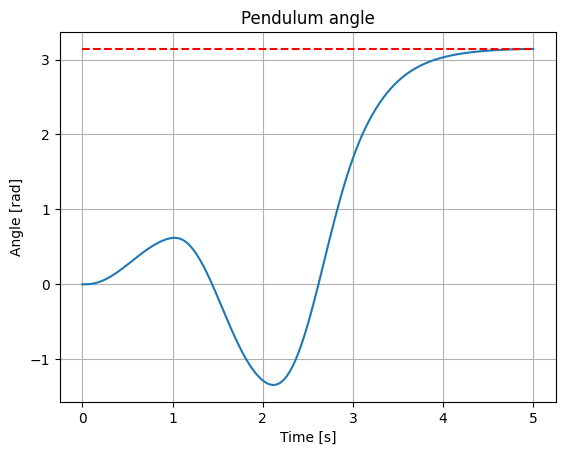

In [10]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Pendulum angle")
plt.grid()
plt.plot(timeseries, q)
plt.hlines(qfinal, 0, T, color="red", linestyle="dashed")
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")

Text(0, 0.5, 'Velocity [rad/s]')

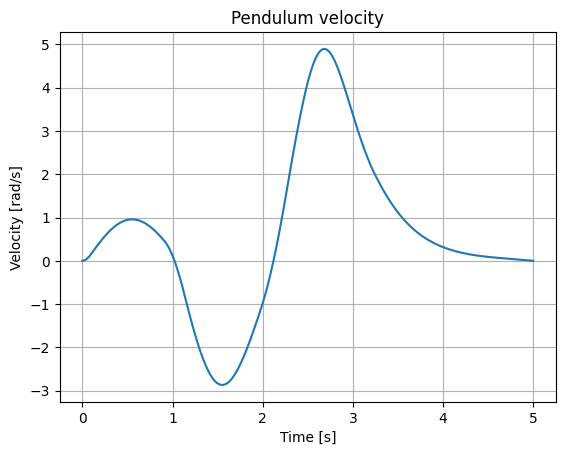

In [11]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Pendulum velocity")
plt.grid()
plt.plot(timeseries, dq)
plt.xlabel("Time [s]")
plt.ylabel("Velocity [rad/s]")

Text(0, 0.5, 'Acceleration [rad/s^2]')

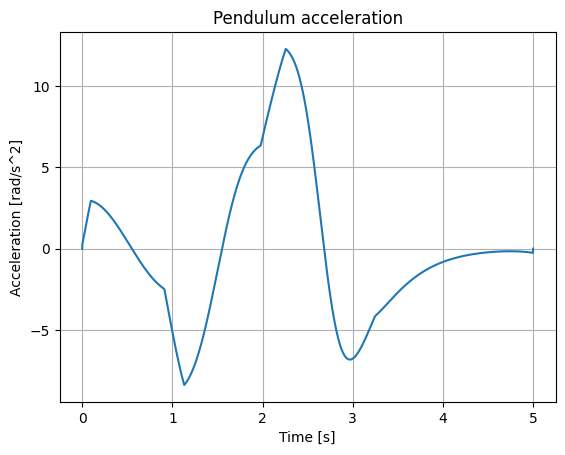

In [12]:
from matplotlib import pyplot as plt

timeseries = cs.linspace(0, T, N)

plt.title("Pendulum acceleration")
plt.grid()
plt.plot(timeseries, ddq)
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [rad/s^2]")

# Torque

As we see our inverse dynamics solution was limited by specified bounds.


Text(0.5, 0, 'Time [s]')

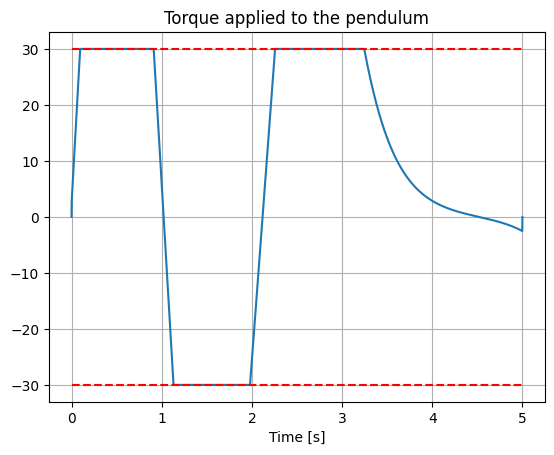

In [13]:
# compute what is the torque applied to the pendulum

from matplotlib import pyplot as plt

tau = []
for i in range(N):
    u = invdyn(q[i], dq[i], ddq[i])
    tau.append(u)

timeseries = cs.linspace(0, T, N)

plt.title("Torque applied to the pendulum")
plt.grid()
plt.plot(timeseries, tau)
plt.hlines([params["u_max"], -params["u_max"]], 0, T, linestyles="dashed", colors="red")
plt.xlabel("Time [s]")